In [7]:
%load_ext autoreload
%autoreload 2
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import cosine sim
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
from sklearn.linear_model import SGDClassifier
# import mlp
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
# import pca
from sklearn.decomposition import PCA
import pickle
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split
import torch
import tqdm
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, AutoConfig
from run_all import fit_optimal_transport, fit_steering_intervention, optimal_transport_simplified, steering_simplified
import ot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_data(path, pca_dim=None, model_name=None):
    fnames = ["neg_neg.npy", "neg_pos.npy", "pos_neg.npy", "pos_pos.npy"]
    if model_name is not None:
        fnames = [model_name+"_"+fname for fname in fnames]
    protected_labels = [0, 1, 0, 1]
    main_labels = [0, 0, 1, 1]
    X, Y_p, Y_m = [], [], []

    for fname, p_label, m_label in zip(fnames, protected_labels, main_labels):
        #print(path + '/' + fname)
        data = np.load(path + '/' + fname)
        for x in data:
            X.append(x)
        for _ in data:
            Y_p.append(p_label)
        for _ in data:
            Y_m.append(m_label)

    Y_p = np.array(Y_p)
    Y_m = np.array(Y_m)
    X = np.array(X)
    X, Y_p, Y_m = shuffle(X, Y_p, Y_m, random_state=1)
    if pca_dim is not None:
        pca = PCA(n_components=pca_dim, random_state=1)
        X = pca.fit_transform(X)
        print("percentage of variance explained by first 256 components: ", np.sum(pca.explained_variance_ratio_[:256]))
        print("percentage of variance explained by first 512 components: ", np.sum(pca.explained_variance_ratio_[:512]))
    return X, Y_p, Y_m


def sample_bias(X,z,y, bias_level=0.1, train_prop = 0.6):
    np.random.seed(0)
    # the goal of this function is to create a biased dataset.
    # in bias_level, we are completely balanced wrt the main task (y), but we are biased wrt the protected attribute (z)
    # e.g, if bias_level=0.1, then the proportions within y=1 will be 0.1 and 0.9 for z=0 and z=1 respectively, and vice versa for y=0

    # first, we need to find the indices of the samples that have the desired label and protected attribute

    X,z,y = shuffle(X,z,y, random_state=1)

    y_1_z_1 = (y==1)&(z==1)
    y_1_z_0 = (y==1)&(z==0)
    y_0_z_1 = (y==0)&(z==1)
    y_0_z_0 = (y==0)&(z==0)

    # now, we need to sample from these indices
    to_sample_from_z_1_y_1 = np.where(y_1_z_1)[0]
    to_sample_from_z_1_y_0 = np.where(y_1_z_0)[0]
    to_sample_from_z_0_y_1 = np.where(y_0_z_1)[0]
    to_sample_from_z_0_y_0 = np.where(y_0_z_0)[0]


    z_1_y_1_sample = np.random.choice(to_sample_from_z_1_y_1, int(len(to_sample_from_z_1_y_1)*bias_level), replace=False)
    z_1_y_0_sample = np.random.choice(to_sample_from_z_1_y_0, int(len(to_sample_from_z_1_y_0)*(1-bias_level)), replace=False)
    z_0_y_1_sample = np.random.choice(to_sample_from_z_0_y_1, int(len(to_sample_from_z_0_y_1)*(1-bias_level)), replace=False)
    z_0_y_0_sample = np.random.choice(to_sample_from_z_0_y_0, int(len(to_sample_from_z_0_y_0)*bias_level), replace=False)

    # now, we need to concatenate these indices

    indices = np.concatenate((z_1_y_1_sample, z_1_y_0_sample, z_0_y_1_sample, z_0_y_0_sample))

    # now, we need to shuffle the indices

    indices = shuffle(indices, random_state=1)

    # split to train,dev,test

    train_indices = indices[:int(len(indices)*train_prop)]
    dev_indices = indices[int(len(indices)*train_prop):int(len(indices)*(train_prop+0.3))]
    test_indices = indices[int(len(indices)*(train_prop+0.3)):]

    return X[train_indices], z[train_indices], y[train_indices], X[dev_indices], z[dev_indices], y[dev_indices], X[test_indices], z[test_indices], y[test_indices]



In [29]:
bias2clf_before = {}
bias2clf_after = {}

bias2data_before = {}
bias2data_after = {}
num_examples = 25000
train_prop = 0.6
for bias_level in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        print("bias level = ", bias_level)
        X,z,y = load_data('tweets-data', pca_dim=768)

        x_train, z_train, y_train, x_dev, z_dev, y_dev, x_test, z_test, y_test = sample_bias(X,z,y, bias_level=bias_level)

        clf = SGDClassifier(loss='log_loss', penalty='l2', random_state=0, max_iter=500000, tol=1e-4)
        clf.fit(x_train, y_train)
        print("score before: ", clf.score(x_dev, y_dev), "majority:", max(Counter(y_dev).values())/len(y_dev))
        bias2clf_before[str(bias_level)] = clf
        bias2data_before[str(bias_level)] = {"x_train": x_train, "y_train": y_train, "z_train": z_train, "x_dev": x_dev, "y_dev": y_dev, "z_dev": z_dev,
                                             "x_test": x_test, "y_test": y_test, "z_test": z_test}
        


        gender_clf = SGDClassifier(loss='log_loss', penalty='l2', random_state=0, max_iter=500000, tol=1e-4)
        gender_clf.fit(x_train, z_train)

        dev_z_pred = gender_clf.predict(x_dev)
        train_z_pred =  gender_clf.predict(x_train)

        #mean_source, mean_target, A, train_x_transformed, dev_x_transformed = optimal_transport_simplified(x_train, train_z_pred, x_dev, dev_z_pred, source=source_class, target=target_class)

        z_labels_train = train_z_pred
        z_labels_dev = dev_z_pred
        
        x_train_source = x_train[z_labels_train==0]
        x_train_target = x_train[z_labels_train==1]
        x_dev_source = x_dev[z_labels_dev==0]
        x_dev_target = x_dev[z_labels_dev==1]

        ot_linear = ot.da.LinearTransport()
        ot_linear.fit(Xs=x_train_source, Xt=x_train_target)
        train_x_transformed = x_train.copy()
        train_x_transformed[z_labels_train==0] = ot_linear.transform(Xs=x_train_source)

        dev_x_transformed = x_dev.copy()
        dev_x_transformed[z_labels_dev==0] = ot_linear.transform(Xs=x_dev_source)


        #train_x_transformed, dev_x_transformed, A, mean_source, mean_target, intervention_module, clf = fit_optimal_transport(x_train, z_train, x_dev, dev_z=z_dev, use_dev_z_for_eval_only=False,
        #                                                                                    use_linear_clf=False, diag_cov=False, use_shrinkage=False)
        bias2data_after[str(bias_level)] = {"x_train": train_x_transformed, "y_train": y_train, "z_train": z_train, "x_dev": dev_x_transformed, "y_dev": y_dev, "z_dev": z_dev,
                                             "x_test": x_test, "y_test": y_test, "z_test": z_test}
        clf_after = SGDClassifier(loss='log_loss', penalty='l2', random_state=0, max_iter=500000, tol=1e-4)
        clf_after.fit(train_x_transformed, y_train)
        print("score after:", clf_after.score(dev_x_transformed, y_dev), "majority:", max(Counter(y_dev).values())/len(y_dev))
        bias2clf_after[str(bias_level)] = clf_after

        



bias level =  0.5
percentage of variance explained by first 256 components:  0.7798785285114793
percentage of variance explained by first 512 components:  0.8790526112169069
score before:  0.758560606060606 majority: 0.5008712121212121
score after: 0.7511363636363636 majority: 0.5008712121212121
bias level =  0.55
percentage of variance explained by first 256 components:  0.7798785285114793
percentage of variance explained by first 512 components:  0.8790526112169069
score before:  0.7683624379711352 majority: 0.5009280654570248
score after: 0.7574529338232509 majority: 0.5009280654570248
bias level =  0.6
percentage of variance explained by first 256 components:  0.7798785285114793
percentage of variance explained by first 512 components:  0.8790526112169069
score before:  0.7775 majority: 0.5008712121212121
score after: 0.7545075757575758 majority: 0.5008712121212121
bias level =  0.65
percentage of variance explained by first 256 components:  0.7798785285114793
percentage of varianc

In [ ]:
bias2clf_before_steer = {}
bias2clf_after_steer = {}

bias2data_before_steer = {}
bias2data_after_steer = {}
num_examples = 25000
train_prop = 0.6
source_class,target_class = 0,1
for bias_level in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        print("bias level = ", bias_level)
        X,z,y = load_data('tweets-data', pca_dim=768)

        x_train, z_train, y_train, x_dev, z_dev, y_dev, x_test, z_test, y_test = sample_bias(X,z,y, bias_level=bias_level)

        clf = SGDClassifier(loss='log_loss', penalty='l2', random_state=0, max_iter=500000, tol=1e-4)
        clf.fit(x_train, y_train)
        print("score before: ", clf.score(x_dev, y_dev), "majority:", max(Counter(y_dev).values())/len(y_dev))
        bias2clf_before_steer[str(bias_level)] = clf
        bias2data_before_steer[str(bias_level)] = {"x_train": x_train, "y_train": y_train, "z_train": z_train, "x_dev": x_dev, "y_dev": y_dev, "z_dev": z_dev,
                                             "x_test": x_test, "y_test": y_test, "z_test": z_test}
        


        gender_clf = SGDClassifier(loss='log_loss', penalty='l2', random_state=0, max_iter=500000, tol=1e-4)
        gender_clf.fit(x_train, z_train)

        dev_z_pred = gender_clf.predict(x_dev)
        train_z_pred =  gender_clf.predict(x_train)

        mean_source, mean_target, train_x_transformed, dev_x_transformed = steering_simplified(x_train, train_z_pred, x_dev, dev_z_pred, source=source_class, target=target_class)


        #train_x_transformed, dev_x_transformed, A, mean_source, mean_target, intervention_module, clf = fit_optimal_transport(x_train, z_train, x_dev, dev_z=z_dev, use_dev_z_for_eval_only=False,
        #                                                                                    use_linear_clf=False, diag_cov=False, use_shrinkage=False)
        bias2data_after_steer[str(bias_level)] = {"x_train": train_x_transformed, "y_train": y_train, "z_train": z_train, "x_dev": dev_x_transformed, "y_dev": y_dev, "z_dev": z_dev,
                                             "x_test": x_test, "y_test": y_test, "z_test": z_test}
        clf_after = SGDClassifier(loss='log_loss', penalty='l2', random_state=0, max_iter=500000, tol=1e-4)
        clf_after.fit(train_x_transformed, y_train)
        print("score after:", clf_after.score(dev_x_transformed, y_dev), "majority:", max(Counter(y_dev).values())/len(y_dev))
        bias2clf_after_steer[str(bias_level)] = clf_after

        



bias level =  0.5
percentage of variance explained by first 256 components:  0.7798785285114793
percentage of variance explained by first 512 components:  0.8790526112169069
score before:  0.758560606060606 majority: 0.5008712121212121
score after: 0.7576893939393939 majority: 0.5008712121212121
bias level =  0.55
percentage of variance explained by first 256 components:  0.7798785285114793
percentage of variance explained by first 512 components:  0.8790526112169069
score before:  0.7683624379711352 majority: 0.5009280654570248
score after: 0.7621500814424789 majority: 0.5009280654570248
bias level =  0.6
percentage of variance explained by first 256 components:  0.7798785285114793
percentage of variance explained by first 512 components:  0.8790526112169069
score before:  0.7775 majority: 0.5008712121212121
score after: 0.7590151515151515 majority: 0.5008712121212121
bias level =  0.65
percentage of variance explained by first 256 components:  0.7798785285114793
percentage of varianc

In [ ]:
with open("results-tweets/results_oracle_steer-llama.pickle", "wb") as f:
    pickle.dump({"bias2clf_before": bias2clf_before_steer, "bias2clf_after": bias2clf_after_steer, "bias2data_before": bias2data_before_steer, 
                 "bias2data_after": bias2data_after_steer}, f)

In [3]:
with open("results-tweets/results_oracle_steer-llama.pickle", "rb") as f:
    dic_steer = pickle.load(f)

In [ ]:
with open("results-tweets/results_oracle-llama.pickle", "wb") as f:
    pickle.dump({"bias2clf_before": bias2clf_before, "bias2clf_after": bias2clf_after, "bias2data_before": bias2data_before, 
                 "bias2data_after": bias2data_after}, f)

In [4]:
with open("results-tweets/results_oracle-llama.pickle", "rb") as f:
    dic_ours = pickle.load(f)

In [5]:
def get_tpr_before_and_after(bias2clf_before, bias2clf_after, bias2data_before, bias2data_after, prop):

  prop = str(prop)
  inp_clf_before = bias2data_before[prop]["x_dev"]
  inp_clf_after = bias2data_after[prop]["x_dev"]
  y_dev = bias2data_after[prop]["y_dev"]
  z_dev = bias2data_before[prop]["z_dev"]

  y_pred = bias2clf_after[prop].predict(inp_clf_after)
  y_pred_original = bias2clf_before[prop].predict(inp_clf_before)
  y_pred_true = y_pred[y_pred==y_dev]


  rms_tpr_gap = 0.0
  rms_tpr_gap_orig = 0.0
  prof2tpr = {}
  prof2tpr_original = {}
  prof2percentfem = {}
  for y in set(y_dev):
    #y_pred[y_train == y] == y
    tpr_1 = (((y_pred[y_dev == y])[z_dev[y_dev==y]==1]) == y).mean()
    tpr_0 =  (((y_pred[y_dev == y])[z_dev[y_dev==y]==0]) == y).mean()
    rms_tpr_gap += (tpr_1 - tpr_0)**2
    prof2tpr[y] = (tpr_1 - tpr_0)**2


    tpr_1_original = (((y_pred_original[y_dev == y])[z_dev[y_dev==y]==1]) == y).mean()
    tpr_0_original = (((y_pred_original[y_dev == y])[z_dev[y_dev==y]==0]) == y).mean()
    rms_tpr_gap_orig += (tpr_1_original - tpr_0_original)**2
    prof2tpr_original[y] = (tpr_1_original - tpr_0_original)

    #prof2percentfem[y] = z_train[y_train==y].mean()
  rms_tpr_gap = np.sqrt(rms_tpr_gap/len(set(y_pred_true)))
  rms_tpr_gap_orig = np.sqrt(rms_tpr_gap_orig/len(set(y_pred_true)))
  return rms_tpr_gap, rms_tpr_gap_orig

In [6]:
tprs_before = []
tprs_after = []
tprs_before_steer = []
tprs_after_steer = []
props = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

bias2clf_before = dic_ours["bias2clf_before"]
bias2clf_after = dic_ours["bias2clf_after"]
bias2data_before = dic_ours["bias2data_before"]
bias2data_after = dic_ours["bias2data_after"]

bias2clf_before_steer = dic_steer["bias2clf_before"]
bias2clf_after_steer = dic_steer["bias2clf_after"]
bias2data_before_steer = dic_steer["bias2data_before"]
bias2data_after_steer = dic_steer["bias2data_after"]


for prop in props:
    tpr_after, tpr_before = get_tpr_before_and_after(bias2clf_before, bias2clf_after, bias2data_before, bias2data_after, prop)
    print(prop, tpr_before, tpr_after)
    tprs_before.append(tpr_before)
    tprs_after.append(tpr_after)

    tpr_after_stter, _ = get_tpr_before_and_after(bias2clf_before_steer, bias2clf_after_steer, bias2data_before_steer, bias2data_after_steer, prop)
    tprs_after_steer.append(tpr_after_stter)


0.5 0.13157767863219152 0.12342270133319257
0.55 0.1768985491662485 0.10540937275104068
0.6 0.22991878512085945 0.0983887675921385
0.65 0.2611291125815641 0.0833066943574088
0.7 0.3122605213797975 0.0970274671647158
0.75 0.34852792947243544 0.07948899898965636
0.8 0.39101729297409327 0.0974947399330934
0.85 0.4338351110523126 0.125499192916331
0.9 0.5082665326783463 0.09428709439823053
0.95 0.585092396032189 0.05337693450309653


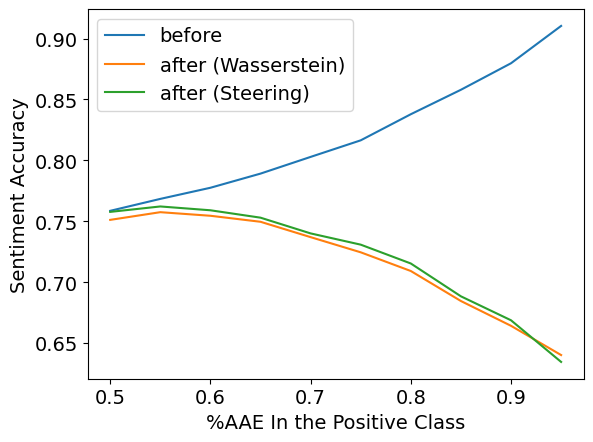

In [8]:
accs_after = [bias2clf_after[str(propr)].score(bias2data_after[str(propr)]["x_dev"], bias2data_after[str(propr)]["y_dev"]) for propr in props]
accs_before = [bias2clf_before[str(propr)].score(bias2data_before[str(propr)]["x_dev"], bias2data_before[str(propr)]["y_dev"]) for propr in props]
accs_After_steer = [bias2clf_after_steer[str(propr)].score(bias2data_after_steer[str(propr)]["x_dev"], bias2data_after_steer[str(propr)]["y_dev"]) for propr in props]

plt.plot(props, accs_before, label="before")
plt.plot(props, accs_after, label="after (Wasserstein)")
plt.plot(props, accs_After_steer, label="after (Steering)")
plt.xlabel("%AAE In the Positive Class", fontsize=14)
plt.ylabel("Sentiment Accuracy", fontsize=14)
# increase font
# increas xticks and yticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
#plt.savefig("results-tweets/acc.pdf", dpi=600)



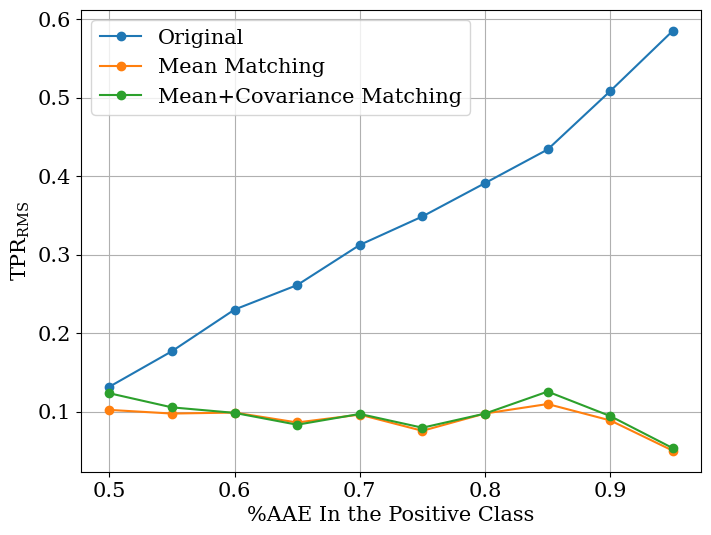

In [17]:
# plot
plt.rcParams["font.family"] = "serif"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(8, 6))

plt.plot(props, tprs_before, label="Original",  marker="o")
plt.plot(props, tprs_after_steer, label="Mean Matching",  marker="o")
plt.plot(props, tprs_after, label="Mean+Covariance Matching",  marker="o")

plt.xlabel("%AAE In the Positive Class", fontsize=15)
plt.ylabel("$\mathregular{TPR_{RMS}}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()

plt.savefig("results-tweets/tpr_gap_llama.pdf", dpi=600)
plt.show()

In [24]:
# createa a df for the results

df = pd.DataFrame({"%AAE": props, "TPR Gap Before": tprs_before, "TPR Gap After (Wasserstein)": tprs_after, "TPR Gap After (Steering)": tprs_after_steer, "Accuracy Before": accs_before, "Accuracy After (Wasserstein)": accs_after, "Accuracy After (Steering)": accs_After_steer})